In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = BlockRNNModel(
        model="GRU",
        model_name=f"model_{fold+1}",
        input_chunk_length=24,
        hidden_dim=188,
        n_rnn_layers=1,
        n_epochs=100,
        batch_size=172,
        dropout=0.463770421977072,
        add_encoders=encoders,
        output_chunk_length=1,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.AdamW,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 0.0020101615632169517, "weight_decay": 4.080126913056516e-06},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.039
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.028
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.026
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.022
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.001 >= min_del

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE        R2  \
Temperature                    5.034443    2.243756    1.769731  0.899472   
Precipitation_accumulated      0.187257    0.432732    0.333744  0.701868   
Humidity                      33.925948    5.824599    4.328430  0.891719   
Wind_Speed_kmh                 0.301024    0.548657    0.434185  0.287364   
Soil_Moisture              54355.690891  233.143070  171.695380  0.912053   
Soil_Temperature               9.631656    3.103491    2.308880  0.867291   
Wind_Dir_Sin                   0.260934    0.510817    0.392718  0.182678   
Wind_Dir_Cos                   0.294701    0.542864    0.409324  0.236259   

                               SMAPE  
Temperature                11.392598  
Precipitation_accumulated  10.416834  
Humidity                    7.049973  
Wind_Speed_kmh             51.261352  
Soil_Moisture        

Metric val_loss improved. New best score: 6.213
Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 6.190
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 6.184
Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 6.166
Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 6.145
Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 6.133
Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 6.114
Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 6.096
Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 6.075
Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 6.053
Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 6.032
Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 6.019
Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 6.002
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                7.951286e+01     8.916998    7.221572 -1.286973   
Precipitation_accumulated  1.341512e+05   366.266551  312.159553 -2.359350   
Humidity                   4.700940e+02    21.681651   18.240659 -2.734867   
Wind_Speed_kmh             8.429772e-01     0.918138    0.807973 -1.566865   
Soil_Moisture              1.333760e+06  1154.885406  974.128207  0.114174   
Soil_Temperature           2.760768e+01     5.254301    3.662062  0.229974   
Wind_Dir_Sin               3.435953e-01     0.586170    0.526911 -0.438970   
Wind_Dir_Cos               3.597194e-01     0.599766    0.520313  0.449383   

                                SMAPE  
Temperature                 54.061906  
Precipitation_accumulated  134.276401  
Humidity                    25.005760  
Wind_Speed_kmh             128.048100  
Soil_Mo

Metric val_loss improved. New best score: 0.009
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    1.313370    1.146024    0.941186  7.660456e-01   
Precipitation_accumulated    168.512966   12.981254   11.283562 -1.408433e+06   
Humidity                       8.276633    2.876914    2.323212  5.175446e-01   
Wind_Speed_kmh                 0.005764    0.075923    0.061379          -inf   
Soil_Moisture              29945.477098  173.047615  154.689175 -2.146468e+01   
Soil_Temperature               2.729598    1.652149    1.222298  5.707769e-01   
Wind_Dir_Sin                   0.004026    0.063455    0.047826          -inf   
Wind_Dir_Cos                   0.008023    0.089574    0.074164          -inf   

                                SMAPE  
Temperature                  6.458265  
Precipitation_accumulated    2.423474  
Humidity                     2.677857  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.005
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: Poss

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   4.750865   2.179648   2.034100    -7.359280   
Precipitation_accumulated    44.333302   6.658326   3.252100 -1342.620122   
Humidity                     10.012616   3.164272   2.641036    -0.031063   
Wind_Speed_kmh                0.034748   0.186408   0.168653         -inf   
Soil_Moisture              4942.216405  70.300899  50.690085     0.859232   
Soil_Temperature              6.704210   2.589249   2.549936   -28.198461   
Wind_Dir_Sin                  0.002682   0.051791   0.043444         -inf   
Wind_Dir_Cos                  0.008177   0.090424   0.085294         -inf   

                                SMAPE  
Temperature                 19.371957  
Precipitation_accumulated    0.700020  
Humidity                     2.924740  
Wind_Speed_kmh             200.000000  
Soil_Moisture   

Metric val_loss improved. New best score: 0.005
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.002
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   2.031264   1.425224   1.204893    0.145592   
Precipitation_accumulated   201.135248  14.182216  12.318555 -708.933685   
Humidity                     32.908025   5.736552   4.832196    0.297975   
Wind_Speed_kmh                0.019076   0.138114   0.095804   -8.218362   
Soil_Moisture              6397.078520  79.981739  62.435385    0.201229   
Soil_Temperature              1.554412   1.246761   0.991497    0.042096   
Wind_Dir_Sin                  0.012552   0.112034   0.055784    0.782025   
Wind_Dir_Cos                  0.020182   0.142064   0.085541    0.770673   

                                SMAPE  
Temperature                 16.866238  
Precipitation_accumulated    2.732108  
Humidity                     5.772149  
Wind_Speed_kmh             188.631679  
Soil_Moisture            

Metric val_loss improved. New best score: 0.027
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     1.593991    1.262534    0.929970    0.829370   
Precipitation_accumulated     665.228331   25.792021   21.108571 -572.334466   
Humidity                       42.245981    6.499691    4.903463    0.634233   
Wind_Speed_kmh                  0.477568    0.691063    0.476200    0.692945   
Soil_Moisture              167810.912962  409.647303  354.364111    0.870456   
Soil_Temperature                4.219446    2.054129    1.472394    0.160795   
Wind_Dir_Sin                    0.349000    0.590762    0.421096    0.270927   
Wind_Dir_Cos                    0.270120    0.519730    0.395754    0.443775   

                                SMAPE  
Temperature                 28.805227  
Precipitation_accumulated    4.728635  
Humidity                     5.503024  
Wind_Speed_kmh              7

Metric val_loss improved. New best score: 0.024
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: Poss

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   2.524660   1.588918   1.205021     0.906669   
Precipitation_accumulated   356.058330  18.869508  16.943254 -1162.551648   
Humidity                     20.227544   4.497504   3.455047     0.866419   
Wind_Speed_kmh                0.493965   0.702827   0.534452     0.588594   
Soil_Moisture              8854.701568  94.099424  74.876452    -0.493142   
Soil_Temperature              0.814268   0.902368   0.739295     0.927134   
Wind_Dir_Sin                  0.391238   0.625490   0.502921     0.271464   
Wind_Dir_Cos                  0.304490   0.551806   0.439917     0.103037   

                                SMAPE  
Temperature                 11.544509  
Precipitation_accumulated    3.721013  
Humidity                     4.241390  
Wind_Speed_kmh              53.166877  
Soil_Moisture   

In [5]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1


BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=188, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.463770421977072, activation=ReLU, model_name=model_1, input_chunk_length=24, n_epochs=100, batch_size=172, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, output_chunk_length=1, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fa7378730e0>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adamw.AdamW'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.0020101615632169517, 'weight_decay': 4.080126913056516e-06})

In [6]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


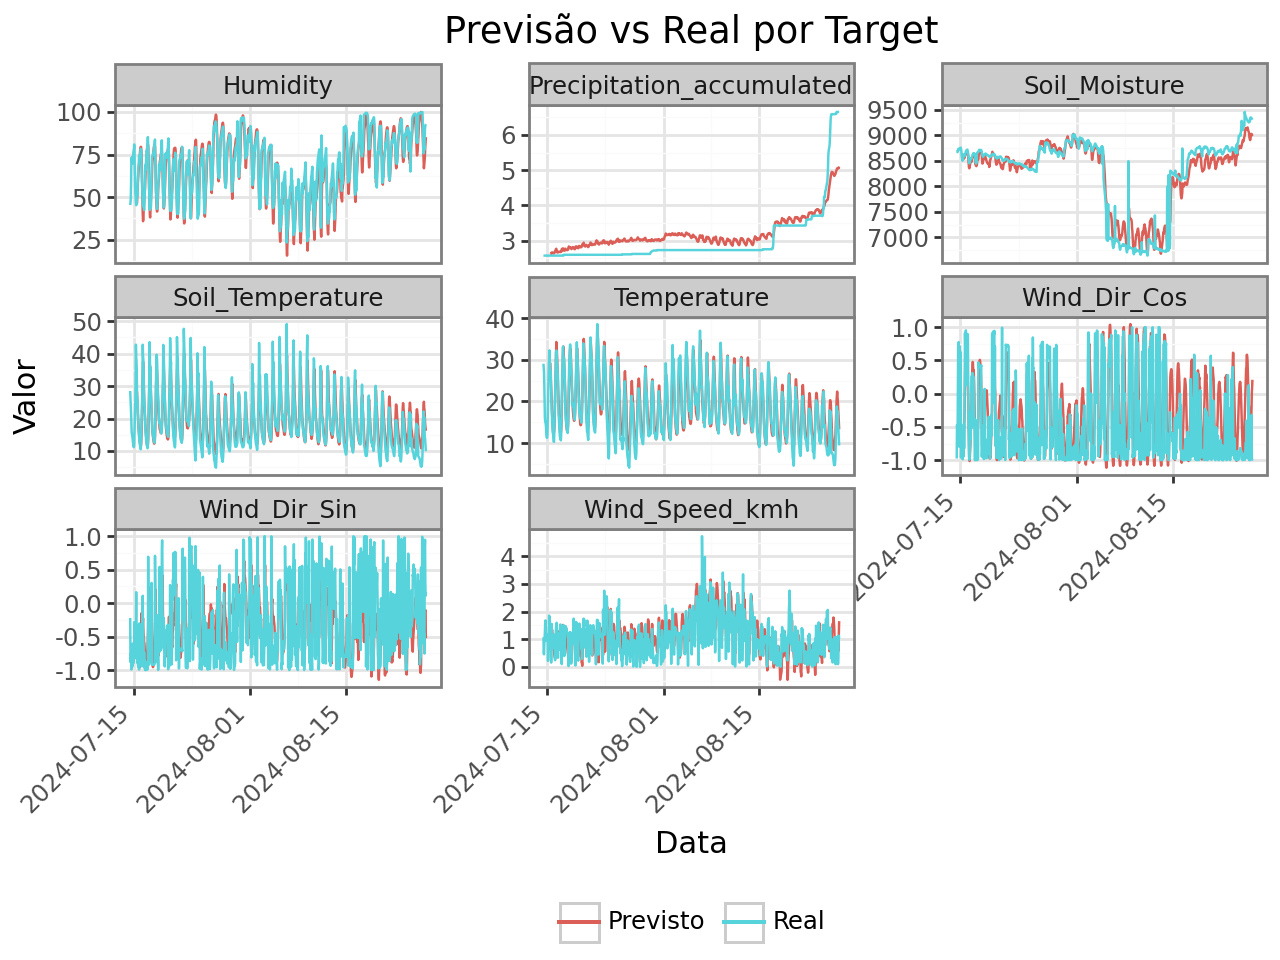

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [7]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [8]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

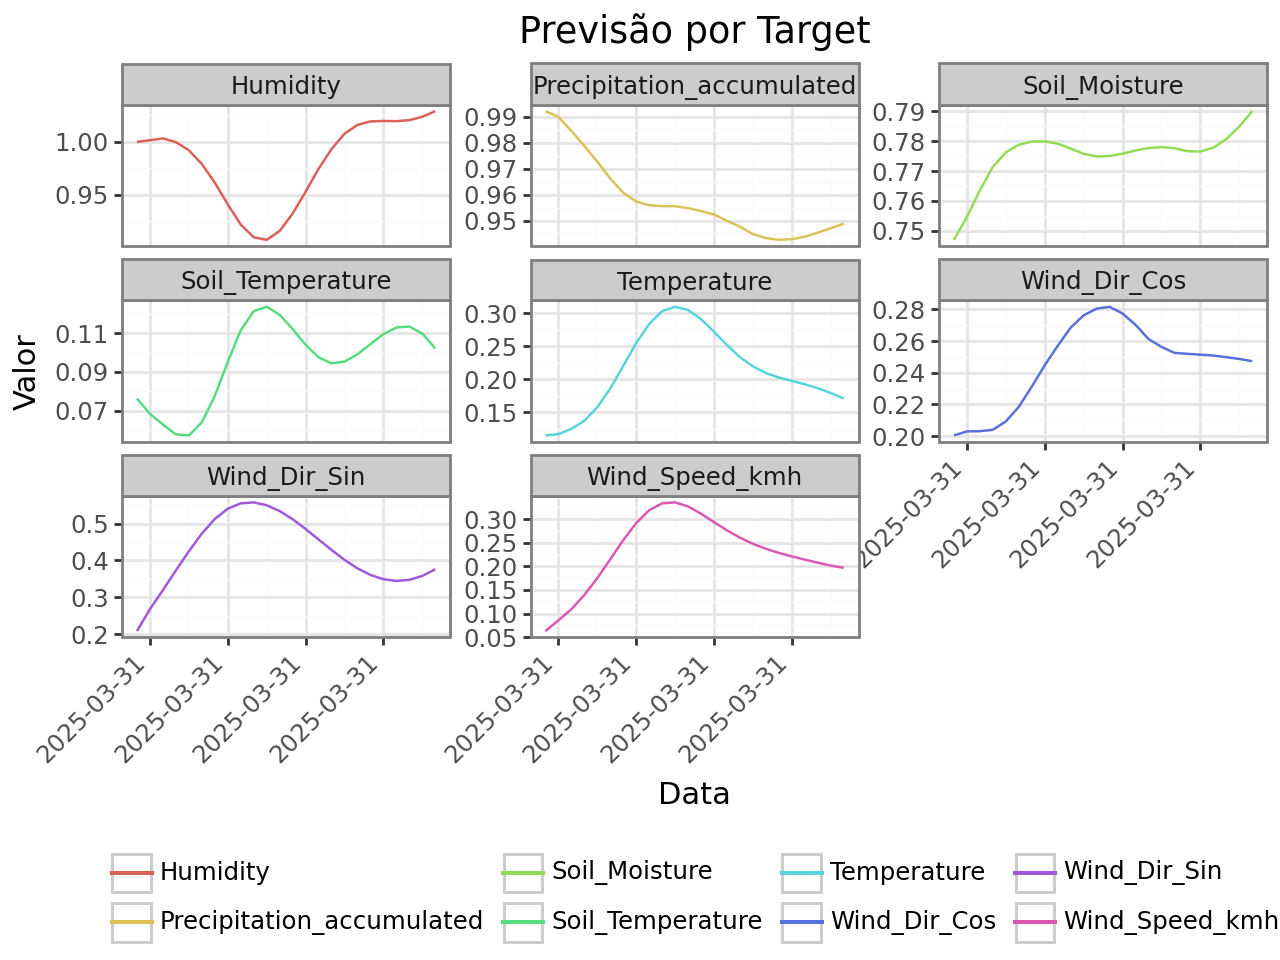

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [9]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [10]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)